# Book Classification
## To classfication different types of Books based on Users, Ratings  

## Import necessary libraries

In [116]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier

In [117]:
import warnings
warnings.filterwarnings('ignore')
# set data directory

## Basic EDA Process


### Loading Datasets


In [118]:
# Initial EDA for Book Recommendation Dataset
sns.set_style("whitegrid")
# locate data directory automatically if P621 missing
DATA_DIR = "P621"
if not os.path.isdir(DATA_DIR):
    # search for a folder containing the required CSV files
    for root, dirs, files in os.walk("."):
        if {"Books.csv", "Ratings.csv", "Users.csv"}.issubset(set(files)):
            DATA_DIR = root
            break
    else:
        # fallback to current directory
        print("Warning: directory 'P621' not found. Searching notebook tree... Using current directory '.' as DATA_DIR.")
        DATA_DIR = "."
print(f"Using DATA_DIR: {DATA_DIR}")

# Load datasets
def load_csv(name):
    path = os.path.join(DATA_DIR, name)
    print(f"Loading {path}...")
    try:
        return pd.read_csv(path)
    except Exception as e:
        raise FileNotFoundError(f"Could not read {path}: {e}")

books = load_csv("Books.csv")
ratings = load_csv("Ratings.csv")
users = load_csv("Users.csv")


Using DATA_DIR: .
Loading .\Books.csv...
Loading .\Ratings.csv...
Loading .\Users.csv...


### Basic data overview and information.

In [119]:
# Quick overview
print("Books:", books.shape)
print("Ratings:", ratings.shape)
print("Users:", users.shape)

display(books.head())
display(ratings.head())
display(users.head())

# Info & dtypes
print("\n--- Books info ---")
display(books.info())
print("\n--- Ratings info ---")
display(ratings.info())
print("\n--- Users info ---")
display(users.info())

# Summary statistics
print("\n--- Books describe ---")
display(books.describe(include='all').transpose())
print("\n--- Ratings describe ---")
display(ratings.describe(include='all').transpose())
print("\n--- Users describe ---")
display(users.describe(include='all').transpose())

Books: (271360, 8)
Ratings: (1149780, 3)
Users: (278858, 3)


ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN


--- Books info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


None


--- Ratings info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


None


--- Users info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


None


--- Books describe ---


count  unique  \
ISBN                 271360  271360   
Book-Title           271360  242135   
Book-Author          271358  102022   
Year-Of-Publication  271360     202   
Publisher            271358   16807   
Image-URL-S          271360  271044   
Image-URL-M          271360  271044   
Image-URL-L          271357  271041   

                                                                   top   freq  
ISBN                                                        0195153448      1  
Book-Title                                              Selected Poems     27  
Book-Author                                            Agatha Christie    632  
Year-Of-Publication                                               2002  13903  
Publisher                                                    Harlequin   7535  
Image-URL-S          http://images.amazon.com/images/P/185326119X.0...      2  
Image-URL-M          http://images.amazon.com/images/P/185326119X.0...      2  
Image-URL-L          http://images.amazon.com/images/P/225307649X.0...      2


--- Ratings describe ---


count  unique         top  freq           mean           std  \
User-ID      1149780.0     NaN         NaN   NaN  140386.395126  80562.277718   
ISBN           1149780  340556  0971880107  2502            NaN           NaN   
Book-Rating  1149780.0     NaN         NaN   NaN        2.86695      3.854184   

             min      25%       50%       75%       max  
User-ID      2.0  70345.0  141010.0  211028.0  278854.0  
ISBN         NaN      NaN       NaN       NaN       NaN  
Book-Rating  0.0      0.0       0.0       7.0      10.0


--- Users describe ---


count unique                              top  freq       mean  \
User-ID   278858.0    NaN                              NaN   NaN   139429.5   
Location    278858  57339  london, england, united kingdom  2506        NaN   
Age       168096.0    NaN                              NaN   NaN  34.751434   

                  std  min       25%       50%        75%       max  
User-ID   80499.51502  1.0  69715.25  139429.5  209143.75  278858.0  
Location          NaN  NaN       NaN       NaN        NaN       NaN  
Age         14.428097  0.0      24.0      32.0       44.0     244.0

### Identify missing values

In [120]:
# Missing values
def missing_summary(df, name=None):
    """
    Return a DataFrame summarizing missing data.
    Treats NaN and empty/whitespace-only strings as missing for object/string columns.
    """
    total = len(df)
    # base null counts
    miss = df.isnull().sum()
    # count empty or whitespace-only strings in object/string columns
    obj_cols = df.select_dtypes(include=['object', 'string']).columns
    empties = pd.Series(0, index=df.columns)
    if len(obj_cols):
        empties_obj = df[obj_cols].fillna('').apply(lambda col: col.str.strip().eq('')).sum()
        empties.update(empties_obj)
    # combine and compute percent
    miss = miss.add(empties, fill_value=0).astype(int)
    pct = (miss / total * 100).round(2)
    uniques = df.nunique(dropna=True)
    return pd.DataFrame({"missing": miss, "percent": pct, "unique": uniques}).sort_values("percent", ascending=False)

print("\n--- Missing values (Books) ---")
display(missing_summary(books, "books"))
print("\n--- Missing values (Ratings) ---")
display(missing_summary(ratings, "ratings"))
print("\n--- Missing values (Users) ---")
display(missing_summary(users, "users"))



--- Missing values (Books) ---


missing  percent  unique
ISBN                       0      0.0  271360
Book-Title                 0      0.0  242135
Book-Author                4      0.0  102022
Year-Of-Publication        0      0.0     202
Publisher                  4      0.0   16807
Image-URL-S                0      0.0  271044
Image-URL-M                0      0.0  271044
Image-URL-L                6      0.0  271041


--- Missing values (Ratings) ---


missing  percent  unique
User-ID            0      0.0  105283
ISBN               0      0.0  340556
Book-Rating        0      0.0      11


--- Missing values (Users) ---


missing  percent  unique
Age        110762    39.72     165
User-ID         0     0.00  278858
Location        0     0.00   57339

### Treat missing values

In [121]:
# Impute/fix missing values
print('\n--- Imputing/fixing missing values ---')
def impute_missing(df, name=None):
    df = df.copy()
    # numeric columns: fill with median
    num = df.select_dtypes(include=[np.number]).columns
    if len(num) > 0:
        df[num] = df[num].fillna(df[num].median())
    # object/categorical: fill with 'Unknown'
    obj = df.select_dtypes(include=['object','category']).columns
    for c in obj:
        df[c] = df[c].fillna('Unknown')
    # special rules
    if 'Age' in df.columns:
        med = int(df.loc[df['Age'].between(1,120),'Age'].median() if not df.loc[df['Age'].between(1,120),'Age'].empty else 30)
        df['Age'] = df['Age'].apply(lambda x: med if pd.isna(x) or x<=0 or x>120 else x)
    if 'Year-Of-Publication' in df.columns:
        df['Year-Of-Publication'] = pd.to_numeric(df['Year-Of-Publication'], errors='coerce')
        df['Year-Of-Publication'] = df['Year-Of-Publication'].fillna(int(df['Year-Of-Publication'].median(skipna=True)))
    return df

# Apply imputation to copies of the loaded DataFrames
books_clean = impute_missing(books, 'books')
ratings_clean = impute_missing(ratings, 'ratings')
users_clean = impute_missing(users, 'users')

# Show missing-value summaries after imputation
print('\n--- Missing values after imputation (Books) ---')
display(missing_summary(books_clean, 'books_clean'))
print('\n--- Missing values after imputation (Ratings) ---')
display(missing_summary(ratings_clean, 'ratings_clean'))
print('\n--- Missing values after imputation (Users) ---')
display(missing_summary(users_clean, 'users_clean'))

# # Save cleaned datasets to DATA_DIR
# books_clean.to_csv(os.path.join(DATA_DIR, 'Books_cleaned.csv'), index=False)
# ratings_clean.to_csv(os.path.join(DATA_DIR, 'Ratings_cleaned.csv'), index=False)
# users_clean.to_csv(os.path.join(DATA_DIR, 'Users_cleaned.csv'), index=False)
# print('\nCleaned files written to DATA_DIR')


--- Imputing/fixing missing values ---

--- Missing values after imputation (Books) ---


missing  percent  unique
ISBN                       0      0.0  271360
Book-Title                 0      0.0  242135
Book-Author                0      0.0  102022
Year-Of-Publication        0      0.0     116
Publisher                  0      0.0   16807
Image-URL-S                0      0.0  271044
Image-URL-M                0      0.0  271044
Image-URL-L                0      0.0  271042


--- Missing values after imputation (Ratings) ---


missing  percent  unique
User-ID            0      0.0  105283
ISBN               0      0.0  340556
Book-Rating        0      0.0      11


--- Missing values after imputation (Users) ---


missing  percent  unique
User-ID         0      0.0  278858
Location        0      0.0   57339
Age             0      0.0     117

### Top value counts for categorical columns

In [122]:
def top_values(df, n=10):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\nTop values for {col}:")
        display(df[col].value_counts(dropna=False).head(n))

top_values(books)
top_values(ratings)
top_values(users)


Top values for ISBN:


ISBN
0195153448    1
0746008481    1
0395219906    1
043916169X    1
0879235322    1
077108482X    1
0207124310    1
0439172543    1
0590408518    1
0902375512    1
Name: count, dtype: int64


Top values for Book-Title:


Book-Title
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
The Secret Garden                 20
Dracula                           20
Adventures of Huckleberry Finn    20
Jane Eyre                         19
The Night Before Christmas        18
Pride and Prejudice               18
Great Expectations                17
Name: count, dtype: int64


Top values for Book-Author:


Book-Author
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: count, dtype: int64


Top values for Year-Of-Publication:


Year-Of-Publication
2002    13903
2001    13715
1999    13414
2000    13373
1998    12116
2003    11610
1997    11494
1996    10687
1995    10259
1994     8857
Name: count, dtype: int64


Top values for Publisher:


Publisher
Harlequin                   7535
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3646
Scholastic                  3160
Simon &amp; Schuster        2971
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: count, dtype: int64


Top values for Image-URL-S:


Image-URL-S
http://images.amazon.com/images/P/185326119X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/006099486X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/044991089X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/086611873X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/039552105X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/038531700X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/067103619X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/156947012X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/096788330X.01.THUMBZZZ.jpg    2
http://images.amazon.com/images/P/006039384X.01.THUMBZZZ.jpg    2
Name: count, dtype: int64


Top values for Image-URL-M:


Image-URL-M
http://images.amazon.com/images/P/185326119X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/006099486X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/044991089X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/086611873X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/039552105X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/038531700X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/067103619X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/156947012X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/096788330X.01.MZZZZZZZ.jpg    2
http://images.amazon.com/images/P/006039384X.01.MZZZZZZZ.jpg    2
Name: count, dtype: int64


Top values for Image-URL-L:


Image-URL-L
NaN                                                             3
http://images.amazon.com/images/P/226401654X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/140003065X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/014062063X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/039552105X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/038531700X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/086611873X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/156947012X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/067103619X.01.LZZZZZZZ.jpg    2
http://images.amazon.com/images/P/096788330X.01.LZZZZZZZ.jpg    2
Name: count, dtype: int64


Top values for ISBN:


ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
044023722X     647
0679781587     639
0142001740     615
067976402X     614
0671027360     586
Name: count, dtype: int64


Top values for Location:


Location
london, england, united kingdom        2506
toronto, ontario, canada               2250
sydney, new south wales, australia     1744
melbourne, victoria, australia         1708
portland, oregon, usa                  1629
chicago, illinois, usa                 1526
seattle, washington, usa               1484
new york, new york, usa                1411
madrid, madrid, spain                  1400
vancouver, british columbia, canada    1359
Name: count, dtype: int64

### Data visualization

<Figure size 600x400 with 0 Axes>

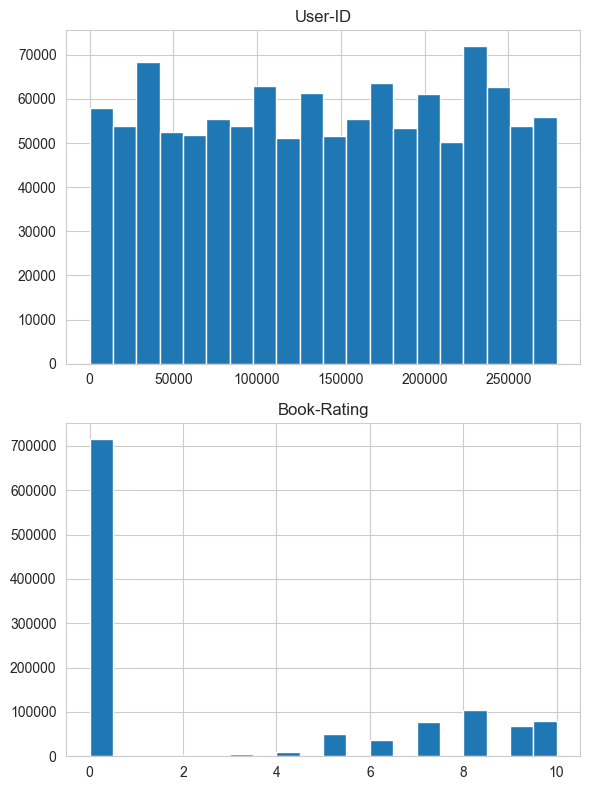

In [123]:
# Basic relationships and distributions
numeric_cols = ratings.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    plt.figure(figsize=(6,4))
    ratings[numeric_cols].hist(bins=20, layout=(len(numeric_cols),1), figsize=(6,4*len(numeric_cols)))
    plt.tight_layout()
    plt.show()

# Ratings distribution and activity
if "Rating" in ratings.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=ratings, x="Rating")
    plt.title("Rating distribution")
    plt.show()

### Unique counts in relationship

In [124]:
# Unique counts in relationships
print("\nUnique users who rated:", ratings['User-ID'].nunique() if 'User-ID' in ratings.columns else ratings.iloc[:,0].nunique())
print("Unique books rated:", ratings['ISBN'].nunique() if 'ISBN' in ratings.columns else ratings.iloc[:,1].nunique())



Unique users who rated: 105283
Unique books rated: 340556


### Top books based on ratings

In [125]:
# Top books by average rating (requires ISBN and Rating)
if {'ISBN', 'Rating'}.issubset(ratings.columns):
    agg = ratings.groupby('ISBN')['Rating'].agg(['mean', 'count']).reset_index().rename(columns={'mean':'avg_rating','count':'n_ratings'})
    top_by_avg = agg[agg['n_ratings']>=5].sort_values(['avg_rating','n_ratings'], ascending=[False, False]).head(15)
    print("\nTop books by avg rating (min 5 ratings):")
    display(top_by_avg.head(15))
    if 'ISBN' in books.columns:
        display(top_by_avg.merge(books, on='ISBN', how='left').head(15))

### Top active users

In [126]:
# Top active users
if 'User-ID' in ratings.columns:
    top_users = ratings['User-ID'].value_counts().head(10)
    print("\nTop active users (by count of ratings):")
    display(top_users)


Top active users (by count of ratings):


User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: count, dtype: int64

### Correlations in numeric columns

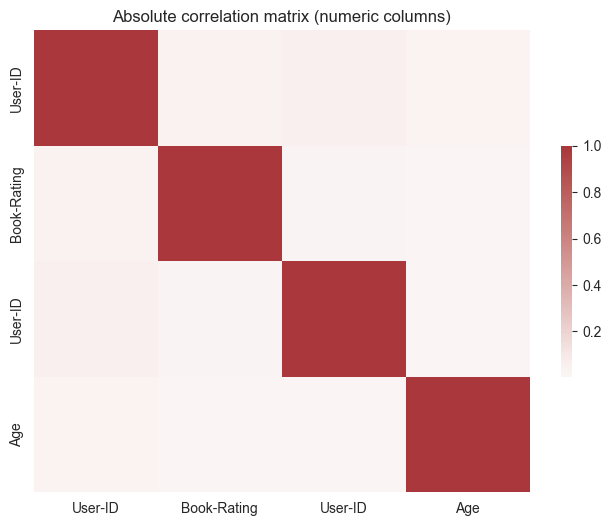

In [127]:
# Correlations (numeric)
num_all = pd.concat([books.select_dtypes(include=[np.number]),
                     ratings.select_dtypes(include=[np.number]),
                     users.select_dtypes(include=[np.number])], axis=1)
if not num_all.empty:
    corr = num_all.corr().abs()
    if not corr.empty:
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, cmap="vlag", center=0, cbar_kws={'shrink':.5})
        plt.title("Absolute correlation matrix (numeric columns)")
        plt.show()


### Duplicate / NULL identification and standardization on cleaned datasets

In [128]:
# work on copies
books_std = books_clean.copy()
ratings_std = ratings_clean.copy()
users_std = users_clean.copy()

def std_col_name(c):
    c = c.strip().lower()
    c = re.sub(r'[\s\-]+', '_', c)
    c = re.sub(r'[^0-9a-z_]', '', c)
    c = re.sub(r'_+', '_', c)
    return c

def standardize_df(df):
    # rename columns to snake_case
    df = df.rename(columns={c: std_col_name(c) for c in df.columns})
    # trim and collapse whitespace for object cols
    obj = df.select_dtypes(include=['object', 'string']).columns
    for c in obj:
        df[c] = df[c].astype(str).str.strip().replace({'': pd.NA}).str.replace(r'\s+', ' ', regex=True)
    return df

# apply standardization of column names and text
books_std = standardize_df(books_std)
ratings_std = standardize_df(ratings_std)
users_std = standardize_df(users_std)

# Identify duplicates
dups = {
    'books_all_duplicates': books_std.duplicated().sum(),
    'books_isbn_duplicates': books_std.duplicated(subset=['isbn']).sum() if 'isbn' in books_std.columns else None,
    'ratings_all_duplicates': ratings_std.duplicated().sum(),
    'ratings_key_duplicates': ratings_std.duplicated(subset=['user_id','isbn']).sum() if {'user_id','isbn'}.issubset(ratings_std.columns) else None,
    'users_all_duplicates': users_std.duplicated().sum(),
    'users_id_duplicates': users_std.duplicated(subset=['user_id']).sum() if 'user_id' in users_std.columns else None
}
print("Duplicate counts:", dups)

# show example duplicate rows (up to 5) for inspection
if dups['books_isbn_duplicates'] and dups['books_isbn_duplicates']>0:
    print("\nSample duplicate ISBNs (books):")
    display(books_std[books_std.duplicated(subset=['isbn'], keep=False)].sort_values('isbn').head(5))
if dups['ratings_key_duplicates'] and dups['ratings_key_duplicates']>0:
    print("\nSample duplicate (user_id,isbn) ratings:")
    display(ratings_std[ratings_std.duplicated(subset=['user_id','isbn'], keep=False)].head(5))
if dups['users_id_duplicates'] and dups['users_id_duplicates']>0:
    print("\nSample duplicate user_ids:")
    display(users_std[users_std.duplicated(subset=['user_id'], keep=False)].head(5))

# Drop duplicates keeping first for primary-key-like subsets
if 'isbn' in books_std.columns:
    books_std = books_std.drop_duplicates(subset=['isbn'], keep='first')
else:
    books_std = books_std.drop_duplicates(keep='first')

if {'user_id','isbn'}.issubset(ratings_std.columns):
    ratings_std = ratings_std.drop_duplicates(subset=['user_id','isbn'], keep='first')
else:
    ratings_std = ratings_std.drop_duplicates(keep='first')

if 'user_id' in users_std.columns:
    users_std = users_std.drop_duplicates(subset=['user_id'], keep='first')
else:
    users_std = users_std.drop_duplicates(keep='first')

print("\nAfter deduplication shapes:")
print("books:", books_std.shape, "ratings:", ratings_std.shape, "users:", users_std.shape)

# NULL / missing summaries (uses missing_summary defined earlier)
print("\nMissing summary (books):")
display(missing_summary(books_std, name='books'))
print("\nMissing summary (ratings):")
display(missing_summary(ratings_std, name='ratings'))
print("\nMissing summary (users):")
display(missing_summary(users_std, name='users'))

# Type coercion and value standardization
current_year = datetime.now().year

# books: year_of_publication -> int and reasonable range
if 'year_of_publication' in books_std.columns:
    books_std['year_of_publication'] = pd.to_numeric(books_std['year_of_publication'], errors='coerce')
    median_year = int(books_std['year_of_publication'].median(skipna=True) or 2000)
    books_std.loc[~books_std['year_of_publication'].between(1450, current_year), 'year_of_publication'] = np.nan
    books_std['year_of_publication'] = books_std['year_of_publication'].fillna(median_year).astype(int)

# users: age -> int and reasonable range
if 'age' in users_std.columns:
    users_std['age'] = pd.to_numeric(users_std['age'], errors='coerce')
    med_age = int(users_std.loc[users_std['age'].between(1,120),'age'].median(skipna=True) or 30)
    users_std.loc[~users_std['age'].between(1,120), 'age'] = med_age
    users_std['age'] = users_std['age'].fillna(med_age).astype(int)

# ratings: book_rating -> int and clamp to 0-10
if 'book_rating' in ratings_std.columns:
    ratings_std['book_rating'] = pd.to_numeric(ratings_std['book_rating'], errors='coerce').fillna(0).astype(int)
    ratings_std['book_rating'] = ratings_std['book_rating'].clip(0, 10)

# normalize location to lowercase trimmed (optional)
if 'location' in users_std.columns:
    users_std['location'] = users_std['location'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip().replace({'': pd.NA})

# Final checks
print("\nFinal dtypes (books):")
print(books_std.dtypes)
print("\nFinal dtypes (ratings):")
print(ratings_std.dtypes)
print("\nFinal dtypes (users):")
print(users_std.dtypes)

# expose standardized variables for downstream cells
books_clean = books_std
ratings_clean = ratings_std
users_clean = users_std

Duplicate counts: {'books_all_duplicates': 1, 'books_isbn_duplicates': 1, 'ratings_all_duplicates': 0, 'ratings_key_duplicates': 0, 'users_all_duplicates': 0, 'users_id_duplicates': 0}

Sample duplicate ISBNs (books):


isbn                                         book_title  \
111653  0486404242  War in Kind: And Other Poems (Dover Thrift Edi...   
111808  0486404242  War in Kind: And Other Poems (Dover Thrift Edi...   

          book_author  year_of_publication           publisher  \
111653  Stephen Crane               1998.0  Dover Publications   
111808  Stephen Crane               1998.0  Dover Publications   

                                              image_url_s  \
111653  http://images.amazon.com/images/P/0486404242.0...   
111808  http://images.amazon.com/images/P/0486404242.0...   

                                              image_url_m  \
111653  http://images.amazon.com/images/P/0486404242.0...   
111808  http://images.amazon.com/images/P/0486404242.0...   

                                              image_url_l  
111653  http://images.amazon.com/images/P/0486404242.0...  
111808  http://images.amazon.com/images/P/0486404242.0...


After deduplication shapes:
books: (271359, 8) ratings: (1149780, 3) users: (278858, 3)

Missing summary (books):


missing  percent  unique
isbn                       0      0.0  271359
book_title                 0      0.0  242092
book_author                0      0.0  101626
year_of_publication        0      0.0     116
publisher                  0      0.0   16807
image_url_s                0      0.0  271044
image_url_m                0      0.0  271044
image_url_l                0      0.0  271042


Missing summary (ratings):


missing  percent  unique
user_id            0      0.0  105283
isbn               0      0.0  340553
book_rating        0      0.0      11


Missing summary (users):


missing  percent  unique
user_id         0      0.0  278858
location        0      0.0   57255
age             0      0.0     117


Final dtypes (books):
isbn                   object
book_title             object
book_author            object
year_of_publication     int32
publisher              object
image_url_s            object
image_url_m            object
image_url_l            object
dtype: object

Final dtypes (ratings):
user_id         int64
isbn           object
book_rating     int32
dtype: object

Final dtypes (users):
user_id      int64
location    object
age          int32
dtype: object


## Model Building

### Feature engineering and extracting

In [129]:
def extract_features(ratings=ratings_std, books=books_std, users=users_std,
                     top_k_authors=50, top_k_publishers=50, save_path=None):
    df = ratings.copy()

    # basic merges
    df = df.merge(users[['user_id','age','location']], on='user_id', how='left')
    df = df.merge(books[['isbn','book_title','book_author','year_of_publication','publisher',
                         'image_url_s','image_url_m','image_url_l']], on='isbn', how='left')

    # target
    y = df['book_rating'].astype(int)

    # user-level aggregations
    user_counts = ratings.groupby('user_id')['book_rating'].agg(user_n_ratings='count', user_avg_rating='mean')
    df = df.merge(user_counts, on='user_id', how='left')

    # book-level aggregations
    book_stats = ratings.groupby('isbn')['book_rating'].agg(book_n_ratings='count', book_avg_rating='mean')
    df = df.merge(book_stats, on='isbn', how='left')

    # popularity / rank
    df['book_popularity_rank'] = df['book_n_ratings'].rank(method='dense', ascending=False).astype('int32')

    # title features
    df['title_len_chars'] = df['book_title'].fillna('').str.len()
    df['title_word_count'] = df['book_title'].fillna('').str.split().str.len()

    # publication recency
    df['year_of_publication'] = pd.to_numeric(df['year_of_publication'], errors='coerce').fillna(int(median_year))
    df['years_since_pub'] = (current_year - df['year_of_publication']).astype(int)

    # author / publisher: keep top-K, map rest to 'other', then label-encode
    top_authors = books['book_author'].value_counts().nlargest(top_k_authors).index
    top_publishers = books['publisher'].value_counts().nlargest(top_k_publishers).index

    df['author_top'] = df['book_author'].where(df['book_author'].isin(top_authors), other='__other__')
    df['publisher_top'] = df['publisher'].where(df['publisher'].isin(top_publishers), other='__other__')

    df['author_code'] = df['author_top'].astype('category').cat.codes
    df['publisher_code'] = df['publisher_top'].astype('category').cat.codes

    # location: extract country (last token after comma) naive approach
    df['country'] = df['location'].fillna('').str.split(',').str[-1].str.strip().replace({'': 'unknown'})
    df['country_code'] = df['country'].astype('category').cat.codes

    # age features: keep age and bucket
    df['age'] = df['age'].fillna(int(med_age)).astype(int)
    df['age_bucket'] = pd.cut(df['age'], bins=[0,17,25,35,50,120], labels=['<18','18-25','26-35','36-50','50+'])
    df['age_bucket_code'] = df['age_bucket'].astype('category').cat.codes

    # image presence flags
    df['has_image_s'] = df['image_url_s'].notna().astype('int8')
    df['has_image_m'] = df['image_url_m'].notna().astype('int8')
    df['has_image_l'] = df['image_url_l'].notna().astype('int8')

    # select feature columns for modeling
    feature_cols = [
        'user_id', 'isbn',
        'age', 'age_bucket_code', 'country_code',
        'user_n_ratings', 'user_avg_rating',
        'book_n_ratings', 'book_avg_rating', 'book_popularity_rank',
        'years_since_pub', 'title_len_chars', 'title_word_count',
        'author_code', 'publisher_code',
        'has_image_s', 'has_image_m', 'has_image_l'
    ]
    X = df[feature_cols].copy()

    # tidy dtypes
    X['user_id'] = X['user_id'].astype('int64')
    X['isbn'] = X['isbn'].astype('category')  # keep as category for potential embedding/encoding later

   
    print(f"Features extracted: X.shape={X.shape}, y.shape={y.shape};")
    return X, y, df

# # run extraction and expose variables for downstream cells
X, y, feature_merge_df = extract_features()
print("Feature DataFrame shape:", feature_merge_df.shape)
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
X.head()


Features extracted: X.shape=(1149780, 18), y.shape=(1149780,);
Feature DataFrame shape: (1149780, 31)
Feature matrix shape: (1149780, 18)
Target vector shape: (1149780,)


user_id        isbn  age  age_bucket_code  country_code  user_n_ratings  \
0   276725  034545104X   32                2           309               1   
1   276726  0155061224   32                2           309               1   
2   276727  0446520802   16                0            19               1   
3   276729  052165615X   16                0            70               2   
4   276729  0521795028   16                0            70               2   

   user_avg_rating  book_n_ratings  book_avg_rating  book_popularity_rank  \
0              0.0              60         2.933333                   273   
1              5.0               2         2.500000                   331   
2              0.0             116         4.060345                   217   
3              4.5               1         3.000000                   332   
4              4.5               1         6.000000                   332   

   years_since_pub  title_len_chars  title_word_count  author_code  \
0               24               20                 4           50   
1               25               16                 3           50   
2               30               12                 2           50   
3               27               14                 3           50   
4               25               62                 9           50   

   publisher_code  has_image_s  has_image_m  has_image_l  
0               4            1            1            1  
1              50            1            1            1  
2              48            1            1            1  
3              50            1            1            1  
4              50            1            1            1

### Label-encode categorical columns in X and save encoders

In [130]:
X = X.copy()
categorical_cols = X.select_dtypes(include=['category','object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    vals = X[col].astype(str).fillna('__na__')
    le.fit(vals)
    X[col] = le.transform(vals).astype('int32')
    label_encoders[col] = le

print("Encoded columns:", categorical_cols)

Encoded columns: ['isbn']


### Standarization

In [131]:
X = X.copy()
id_cols = [c for c in ['user_id', 'isbn'] if c in X.columns]

num_cols_to_scale = [c for c in X.columns if c not in id_cols and pd.api.types.is_numeric_dtype(X[c])]
if not num_cols_to_scale:
    print("No numeric feature columns to scale.")
else:
    scaler = StandardScaler()
    X_num = X[num_cols_to_scale].astype(float)
    X[num_cols_to_scale] = scaler.fit_transform(X_num)
    # expose scaler and scaled column list for downstream use
    scaled_feature_cols = num_cols_to_scale
    print(f"Scaled {len(scaled_feature_cols)} columns: {scaled_feature_cols}")

Scaled 16 columns: ['age', 'age_bucket_code', 'country_code', 'user_n_ratings', 'user_avg_rating', 'book_n_ratings', 'book_avg_rating', 'book_popularity_rank', 'years_since_pub', 'title_len_chars', 'title_word_count', 'author_code', 'publisher_code', 'has_image_s', 'has_image_m', 'has_image_l']


### Regenerate features after encoding and scaling

In [144]:
id_cols = [c for c in ['user_id','isbn'] if c in feature_merge_df.columns]
feat_use = [c for c in scaled_feature_cols if c not in id_cols]
X = feature_merge_df[id_cols + feat_use].copy()

# label-encode categorical columns (reuse/update label_encoders)
categorical_cols = X.select_dtypes(include=['category','object']).columns.tolist()
for col in categorical_cols:
    vals = X[col].astype(str).fillna('__na__')
    le = label_encoders.get(col) if 'label_encoders' in globals() else None
    if le is None:
        le = LabelEncoder()
        le.fit(vals)
        if 'label_encoders' in globals():
            label_encoders[col] = le
        else:
            label_encoders = {col: le}
    X[col] = le.transform(vals).astype('int32')

# ensure id types
if 'user_id' in X.columns:
    X['user_id'] = X['user_id'].astype('int64')

# scale numeric feature columns (reuse existing scaler if available)
if 'scaled_feature_cols' in globals() and scaled_feature_cols:
    num_cols_to_scale = [c for c in scaled_feature_cols if c in X.columns and c not in id_cols]
else:
    num_cols_to_scale = [c for c in X.columns if c not in id_cols and pd.api.types.is_numeric_dtype(X[c])]

if num_cols_to_scale:
    if 'scaler' in globals() and scaler is not None:
        X[num_cols_to_scale] = scaler.transform(X[num_cols_to_scale].astype(float))
    else:
        scaler = StandardScaler()
        X[num_cols_to_scale] = scaler.fit_transform(X[num_cols_to_scale].astype(float))
    scaled_feature_cols = num_cols_to_scale

print("Regenerated X.shape:", X.shape)
X.head()

Regenerated X.shape: (1149780, 18)


user_id    isbn       age  age_bucket_code  country_code  user_n_ratings  \
0   276725   57177 -0.329966        -0.366956      0.551007       -0.417861   
1   276726   29739 -0.329966        -0.366956      0.551007       -0.417861   
2   276727  107381 -1.771677        -2.632519     -2.509720       -0.417861   
3   276729  127242 -1.771677        -2.632519     -1.971454       -0.417311   
4   276729  127276 -1.771677        -2.632519     -1.971454       -0.417311   

   user_avg_rating  book_n_ratings  book_avg_rating  book_popularity_rank  \
0        -1.252169        0.070940         0.029576             -0.312284   
1         0.931631       -0.309516        -0.163491              0.524381   
2        -1.252169        0.438277         0.531704             -1.120098   
3         0.713251       -0.316076         0.059279              0.538807   
4         0.713251       -0.316076         1.395895              0.538807   

   years_since_pub  title_len_chars  title_word_count  author_code  \
0        -0.979432        -0.388739         -0.224124     0.222817   
1        -0.833951        -0.554568         -0.480324     0.222817   
2        -0.106547        -0.720397         -0.736524     0.222817   
3        -0.542989        -0.637483         -0.480324     0.222817   
4        -0.833951         1.352469          1.056877     0.222817   

   publisher_code  has_image_s  has_image_m  has_image_l  
0       -2.080064     0.339202     0.339202     0.339202  
1        0.679890     0.339202     0.339202     0.339202  
2        0.559892     0.339202     0.339202     0.339202  
3        0.679890     0.339202     0.339202     0.339202  
4        0.679890     0.339202     0.339202     0.339202

### Recommender system 

In [ ]:
# =====================================================
# Recommender System – CF + Content-Based (One Cell)
# =====================================================

import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------
# Load data
# -------------------------
ratings = pd.read_csv("Ratings.csv")
books = pd.read_csv("Books.csv", low_memory=False)

ratings = ratings.rename(columns={
    'User-ID': 'user_id',
    'ISBN': 'isbn',
    'Book-Rating': 'book_rating'
})

books = books.rename(columns={
    'ISBN': 'isbn',
    'Book-Title': 'title',
    'Book-Author': 'author'
})

ratings = ratings[['user_id', 'isbn', 'book_rating']]
books = books[['isbn', 'title', 'author']].drop_duplicates()

# -------------------------
# ---------- CF ----------
# -------------------------

# Factorize IDs (SAFE)
ratings['user_idx'], user_ids = pd.factorize(ratings['user_id'])
ratings['item_idx'], item_ids = pd.factorize(ratings['isbn'])

# Aggregate duplicate ratings
ratings_cf = (
    ratings
    .groupby(['user_idx', 'item_idx'], as_index=False)
    ['book_rating']
    .mean()
)

num_users = ratings_cf['user_idx'].nunique()
num_items = ratings_cf['item_idx'].nunique()

# Sparse user–item matrix
user_item_mat = coo_matrix(
    (
        ratings_cf['book_rating'],
        (ratings_cf['user_idx'], ratings_cf['item_idx'])
    ),
    shape=(num_users, num_items)
).tocsr()

# Train KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_mat)

# Index mappings
idx_to_user = dict(enumerate(user_ids))
idx_to_isbn = dict(enumerate(item_ids))

book_lookup = books.set_index('isbn').to_dict('index')

# CF recommendation
def recommend_cf(user_id, n=5):
    if user_id not in user_ids.values:
        return pd.DataFrame()

    user_idx = np.where(user_ids == user_id)[0][0]
    k = min(11, user_item_mat.shape[0])

    _, nbrs = knn.kneighbors(user_item_mat[user_idx], n_neighbors=k)
    nbrs = [i for i in nbrs.flatten() if i != user_idx]

    scores = user_item_mat[nbrs].sum(axis=0).A1
    seen = set(user_item_mat[user_idx].nonzero()[1])
    scores[list(seen)] = -np.inf

    top_idx = np.argpartition(-scores, range(min(n, len(scores))))[:n]

    return pd.DataFrame([
        {
            'ISBN': idx_to_isbn[i],
            'Title': book_lookup.get(idx_to_isbn[i], {}).get('title', 'Unknown'),
            'Author': book_lookup.get(idx_to_isbn[i], {}).get('author', 'Unknown')
        }
        for i in top_idx
    ])

# -------------------------
# ----- Content-Based -----
# -------------------------

# Build item content
books['content'] = (
    books['title'].fillna('') + " " +
    books['author'].fillna('')
)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books['content'])

isbn_to_tfidf_idx = {isbn: i for i, isbn in enumerate(books['isbn'])}

# Content-based recommendation (user-profile based)
def recommend_content(user_id, n=5, min_profile_items=3):
    """
    Guaranteed content-based recommendations.
    Fallback order:
    1. Positive ratings
    2. Implicit interactions
    3. Global popularity
    """

    # ---- User interactions ----
    user_ratings = ratings[ratings.user_id == user_id]

    # Fallback 3: no interaction at all → popularity
    if user_ratings.empty:
        popular = (
            ratings.groupby('isbn')['book_rating']
            .count()
            .sort_values(ascending=False)
            .head(n)
            .index
        )
        return (
            books[books.isbn.isin(popular)]
            [['isbn', 'title', 'author']]
            .rename(columns={'isbn': 'ISBN', 'title': 'Title', 'author': 'Author'})
        )

    # ---- Step 1: explicit positive ratings ----
    positives = user_ratings[user_ratings.book_rating > 0]

    # ---- Step 2: implicit fallback ----
    if len(positives) < min_profile_items:
        positives = user_ratings.sample(
            min(len(user_ratings), min_profile_items),
            random_state=42
        )

    # ---- Build user profile ----
    vectors = []
    for _, row in positives.iterrows():
        idx = isbn_to_tfidf_idx.get(row['isbn'])
        if idx is not None:
            vectors.append(tfidf_matrix[idx].toarray()[0])

    # Fallback 3 again (extreme edge case)
    if not vectors:
        popular = (
            ratings.groupby('isbn')['book_rating']
            .count()
            .sort_values(ascending=False)
            .head(n)
            .index
        )
        return (
            books[books.isbn.isin(popular)]
            [['isbn', 'title', 'author']]
            .rename(columns={'isbn': 'ISBN', 'title': 'Title', 'author': 'Author'})
        )

    user_profile = np.mean(vectors, axis=0)

    # ---- Similarity ----
    sims = cosine_similarity(
        user_profile.reshape(1, -1),
        tfidf_matrix
    ).flatten()

    # Exclude seen items
    seen = set(user_ratings['isbn'])
    for isbn in seen:
        if isbn in isbn_to_tfidf_idx:
            sims[isbn_to_tfidf_idx[isbn]] = -np.inf

    # ---- Top-N ----
    top_idx = sims.argsort()[::-1][:n]

    return (
        books.iloc[top_idx][['isbn', 'title', 'author']]
        .rename(columns={'isbn': 'ISBN', 'title': 'Title', 'author': 'Author'})
    )

# -------------------------
# Example usage
# -------------------------
example_user_idx = ratings['user_idx'].iloc[0]
example_user_id = idx_to_user[example_user_idx]

print("User ID:", example_user_id)

print("\nCollaborative Filtering:")
display(recommend_cf(example_user_id, 5))

print("\nContent-Based Filtering:")
display(recommend_content(example_user_id, 5))


User ID: 276725

Collaborative Filtering:


ISBN                         Title               Author
0  3423202947               Hunde von Riga.      Henning Mankell
1  0375758275  The Polish Officer : A Novel           ALAN FURST
2  3518388029          Der unendliche Plan.       Isabel Allende
3  0671659553             Binstead's Safari       Rachel Ingalls
4  3404148576                    Nordermoor  Arnaldur Indridason


Content-Based Filtering:


ISBN                                  Title              Author
157747  0345451058                            Flesh Tones          M. J. Rose
120401  0375431292               Flesh and Blood: A Novel  Jonathan Kellerman
140991  0671876228  A DIFFERENT FLESH : A DIFFERENT FLESH    Harry Turtledove
214533  0394494377               Flesh and Blood: A Novel        Pete, Hamill
150586  0812521102                                  Flesh      Richard Laymon

## Building other models for analysis

### Getting X and y variables from dataset

In [134]:
# Keep only explicit ratings
ratings_explicit = ratings[ratings['Book-Rating'] > 0]

# Merge datasets
final_data = ratings_explicit.merge(books, on='ISBN')

# Create rating class
def rating_class(r):
    if r >= 8:
        return "High"
    elif r >= 5:
        return "Medium"
    else:
        return "Low"

final_data['Rating_Class'] = final_data['Book-Rating'].apply(rating_class)

# Text feature
final_data['text'] = (
    final_data['Book-Title'].fillna('') + " " +
    final_data['Book-Author'].fillna('') + " " +
    final_data['Publisher'].fillna('')
)

X = final_data['text']
y = final_data['Rating_Class']

### Training and testing dataset

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Naive Bayes

In [136]:
nb_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000)),
    ('model', MultinomialNB())
])

nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_f1 = f1_score(y_test, nb_pred, average='weighted')

print("Naive Bayes F1:", f1_score(y_test, nb_pred, average='weighted'))

Naive Bayes F1: 0.4893455724360317


### Logistics Regression

In [137]:
lr_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000)),
    ('model', LogisticRegression(max_iter=1000))
])

lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_f1=f1_score(y_test, lr_pred, average='weighted')

print("Logistic Regression F1:", f1_score(y_test, lr_pred, average='weighted'))


Logistic Regression F1: 0.5133185186682191


### Linear SVC

In [138]:
svm_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000)),
    ('model', LinearSVC())
])

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_f1=f1_score(y_test, svm_pred, average='weighted')

print("Linear SVM F1:", f1_score(y_test, svm_pred, average='weighted'))

Linear SVM F1: 0.5125632290341394


### SGD 

In [139]:
sgd_log_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000)),
    ('model', SGDClassifier(
        loss='log_loss',     # logistic regression
        max_iter=1000,
        random_state=42
    ))
])

sgd_log_model.fit(X_train, y_train)
sgd_log_pred = sgd_log_model.predict(X_test)

sgd_log_f1 = f1_score(y_test, sgd_log_pred, average='weighted')
sgd_log_acc = accuracy_score(y_test, sgd_log_pred)

print("SGD Logistic Accuracy:", sgd_log_acc)
print("SGD Logistic F1:", sgd_log_f1)
print(classification_report(y_test, sgd_log_pred))

SGD Logistic Accuracy: 0.5888705076267764
SGD Logistic F1: 0.4602723489282959
              precision    recall  f1-score   support

        High       0.59      0.98      0.74     44762
         Low       0.00      0.00      0.00      3318
      Medium       0.55      0.04      0.08     28689

    accuracy                           0.59     76769
   macro avg       0.38      0.34      0.27     76769
weighted avg       0.55      0.59      0.46     76769



### Ploting model comparison

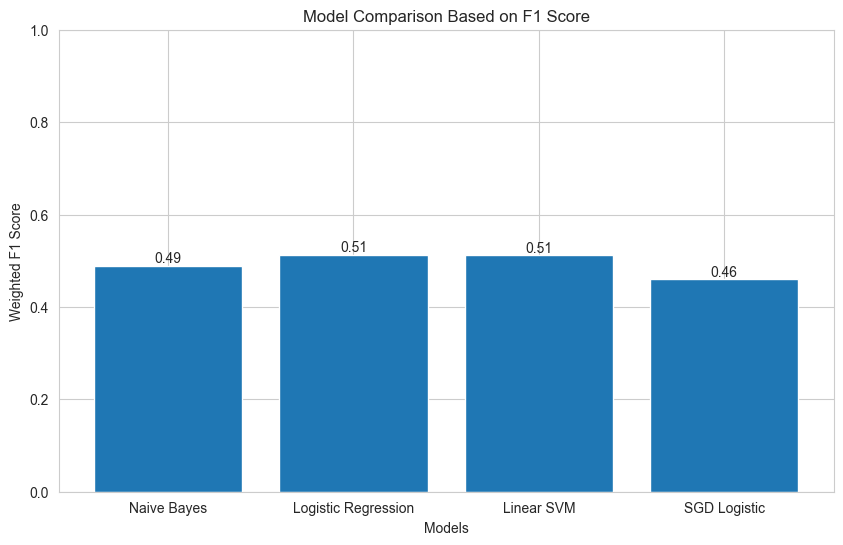

In [140]:
models = [
    "Naive Bayes",
    "Logistic Regression",
    "Linear SVM",
    "SGD Logistic"
]

f1_scores = [
    nb_f1,
    lr_f1,
    svm_f1,
    sgd_log_f1
]

plt.figure(figsize=(10,6))
bars = plt.bar(models, f1_scores)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.2f}",
        ha='center',
        va='bottom'
    )

plt.xlabel("Models")
plt.ylabel("Weighted F1 Score")
plt.title("Model Comparison Based on F1 Score")
plt.ylim(0, 1)
plt.show()
